In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import itertools
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [2]:
def nmf_metrics(nmf, w, tfidf_vectorizer, plot=False):
    """Prints out the accuracy and optionally makes a plot displaying the top 10 words and categories for the nmf model results"""
    # use the label fiting function from week 2 assign catagories to each document and calculate the accuracy
    best_label, acc = label_permute_compare(df_train.Category, get_predictions(w))
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
    if plot:
        # make a plot showing each catagory and its top words
        plot_top_words(nmf, tfidf_feature_names, 10, "NMF", best_label)
    return acc

def get_predictions(w):
    '''Once you have your w matrix this will return which column had the highest value
    ie which category the article is predicted to be'''
    predictions = np.argmax(w, axis=1)
    return predictions

def label_permute_compare(true_, predicted, n=5):
    '''Gets the combination of labels that results in the highest accuracy'''
    perms = itertools.permutations(['business', 'tech', 'politics', 'sport', 'entertainment'])
    
    acc = 0.0
    best_order = 0
    for perm in perms:
        pred = [perm[i] for i in predicted]
        pred_acc = sum([1 for x, y, in zip(list(true_), pred) if x == y]) / len(true_)
        if pred_acc > acc:
            acc = pred_acc
            best_order = perm
            
    return best_order, acc

def show_words_for_topics(topic, words,  num_words = 10):
    '''Takes the H matrix from nmf and a matrix of the words in the text. Picks the num_words with the highest 
    score for each category and returns them'''
    return np.apply_along_axis(lambda x: words[(np.argsort(-x))[:num_words]], 1, topic)

def plot_top_words(model, feature_names, n_top_words, title, subtitles):
    '''Takes the nmf model, a list of category names and some styling information for the graph.
    It then plots a horizontal bar chart for each category. Modified from the sklearn example here
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html'''
    
    fig, axes = plt.subplots(1, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(subtitles[topic_idx], fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

In [3]:
# import the filter words lists
with open('train_filter_words.txt') as f:
    train_filter_words = f.read().splitlines()

with open('test_filter_words.txt') as f:
    test_filter_words = f.read().splitlines()

# import data
df_train = pd.read_csv('BBC News Train.csv')
df_test = pd.read_csv('BBC News Test.csv')

Before we can run NMF we need to vectorise the data, one method to do that is TFID. TFID stands for Term Frequency Inverse Document Frequency. The idea is that common words that appear across many documents won't help in classification and are weighted less while words that appear in fewer documents are weighted more. The frequency a term is used in a single document is also considered and is weighted more heavily the more it is used. From sklearn the equation is “tf-idf(t, d) = tf(t, d) * idf(t), and the idf is computed as idf(t) = log [ n / df(t) ] + 1 (if smooth_idf=False ), where n is the total number of documents in the document set and df(t) is the document frequency of t.”

To do that calculation the TfidfVectorizer first has to turn the raw text data into vectors. That is done by creating a dictionary where each word is assigned a token. A matrix is then created with the rows representing documents and the columns representing tokens (or words). 

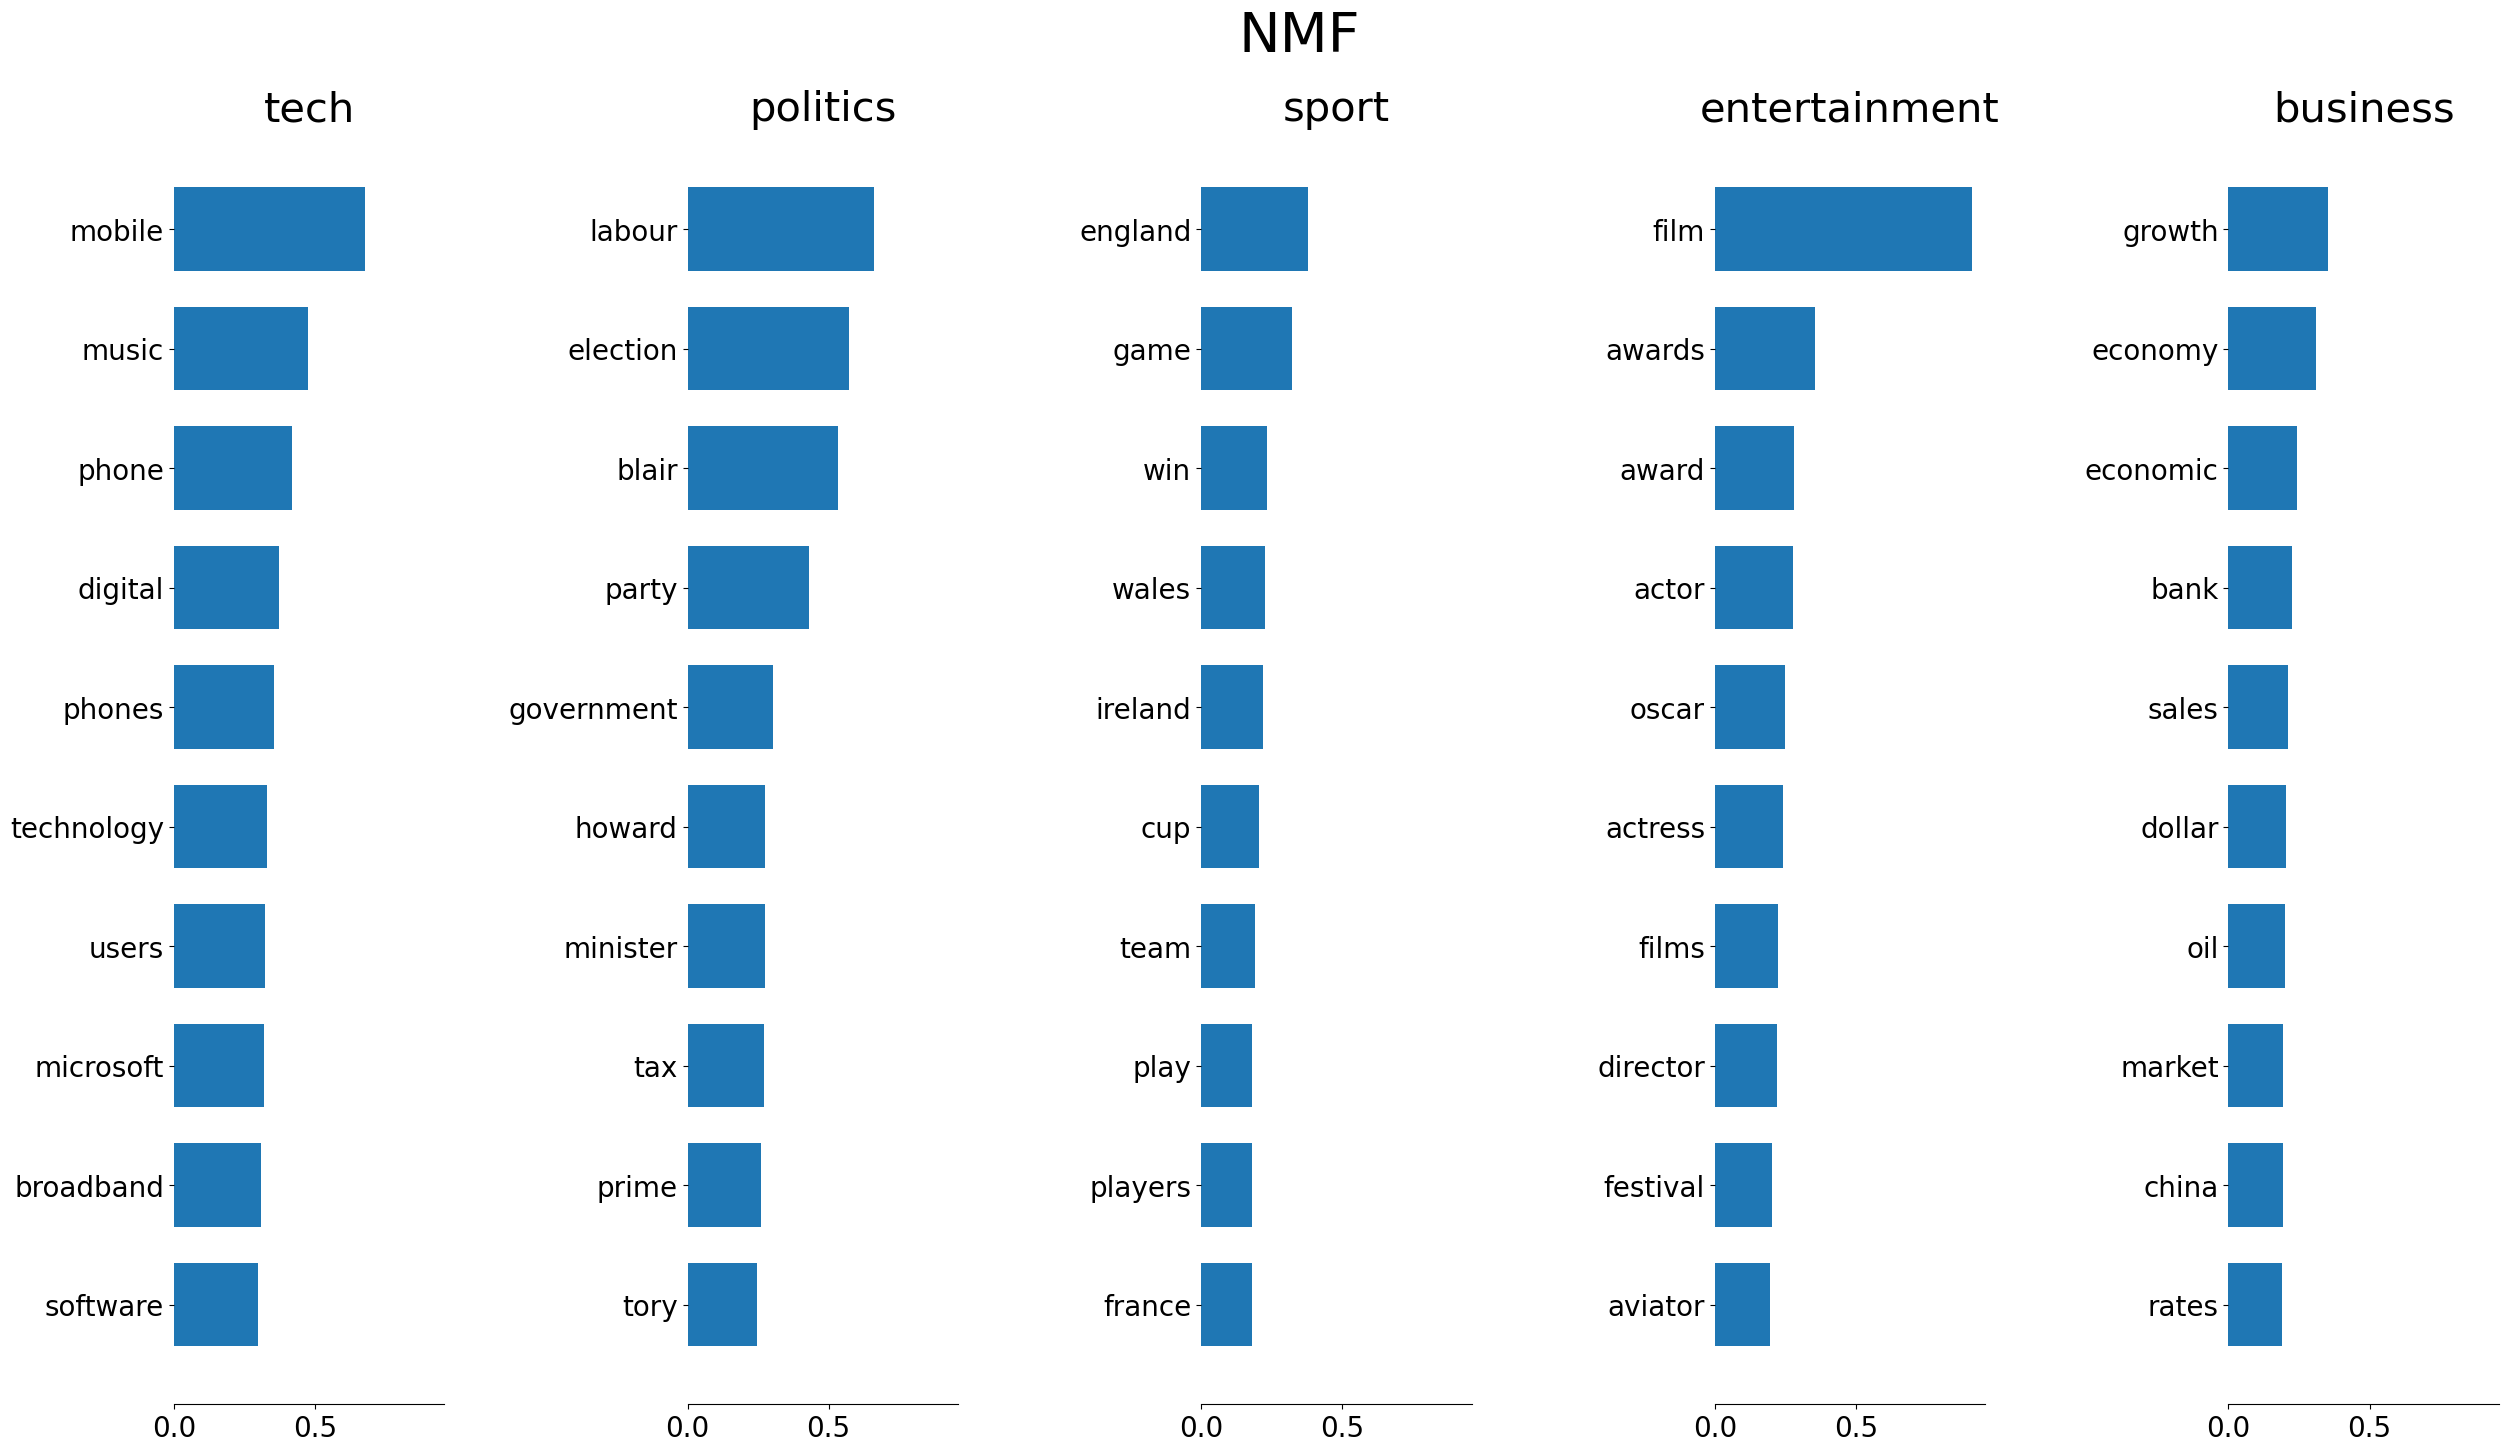

the model accuracy was : 0.9080536912751678


In [27]:
# vectorize the text using the tfidf method
def run_nmf_train(min_df = 0, max_df = 1, plot = False, use_df = False):
    if use_df == True:
        tfidf_vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df)
    else:
        tfidf_vectorizer = TfidfVectorizer(stop_words=train_filter_words)
    tfidf = tfidf_vectorizer.fit_transform(df_train.Text.to_numpy())
    
    # make the nmf modle and set n_componets = to 5 because we have 5 catogries.
    nmf = NMF(n_components = 5, random_state = 0)
    # run the modle
    w = nmf.fit_transform(tfidf)
    
    acc = nmf_metrics(nmf, w, tfidf_vectorizer, plot=plot)
    return acc
    
acc = run_nmf_train(plot=True)
print('the model accuracy was : %s' % acc)

The TfidfVectorizer can create its own filter words based on the frequency the words appear in the documents. Lets see if I can do 
a better job picking filter words or if adjusting the max and min frequency requimernts produces better results.

In [28]:
max_df_list = list(range(100,0, -5))
max_df_list =[.01* val for val in max_df_list]

min_df_list = list(range(0,11, 1))
min_df_list =[.01* val for val in min_df_list]
acc_dict = {}
for max_df in max_df_list:
    for min_df in min_df_list:
        if max_df > min_df:
            acc = run_nmf_train(max_df = max_df, min_df = min_df, use_df = True)
            acc_dict[(max_df, min_df)] = acc

/Users/benkupernk/opt/anaconda3/envs/pycharm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/benkupernk/opt/anaconda3/envs/pycharm/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


The best model has an accuracy of 0.9456375838926174 with a max frequency of 0.1 and a minimum frequency of 0.01.


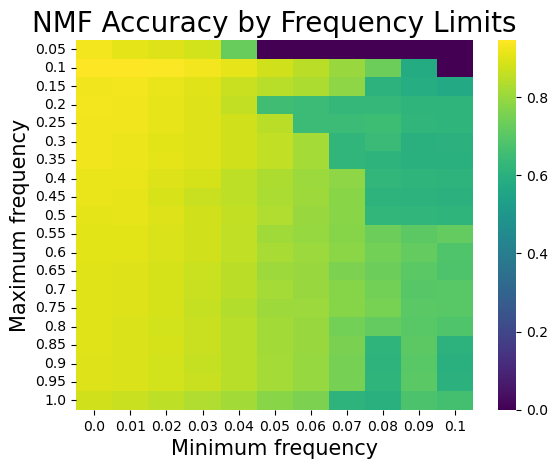

In [36]:
ser = pd.Series(list(acc_dict.values()),
                  index=pd.MultiIndex.from_tuples(acc_dict.keys()))
df_acc_results = ser.unstack().fillna(0)
df_acc_results.index = [round(idx, 2) for idx in df_acc_results.index]
ax = sns.heatmap(df_acc_results, cmap = 'viridis') 

plt.title('NMF Accuracy by Frequency Limits', fontsize = 20)
plt.xlabel('Minimum frequency', fontsize = 15)
plt.ylabel('Maximum frequency', fontsize = 15)
print('The best model has an accuracy of %s with a max frequency of %s and a minimum frequency of %s.' % 
     (max(acc_dict.values()), max(acc_dict, key=acc_dict.get)[0], max(acc_dict, key=acc_dict.get)[1]))  

Now let's run NMF with the test filter list

In [66]:
# vectorize the text using the tfidf method
tfidf_vectorizer = TfidfVectorizer(stop_words=test_filter_words)
tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# make the nmf modle and set n_componets = to 5 because we have 5 catogries.
nmf = NMF(n_components = 5, random_state = 0)
# run the modle
w = nmf.fit_transform(tfidf)

In [67]:
# get my predicted catagories
predictions = get_predictions(w)
# see the top ten words for each catagory
vocab = tfidf_vectorizer.get_feature_names_out()
print(show_words_for_topics(nmf.components_, tfidf_vectorizer.get_feature_names_out()))
print(df_train.Category.unique())

[['music' 'mobile' 'technology' 'digital' 'users' 'broadband' 'games'
  'apple' 'phone' 'computer']
 ['labour' 'election' 'blair' 'brown' 'party' 'howard' 'chancellor'
  'government' 'tax' 'tory']
 ['economy' 'growth' 'bank' 'prices' 'oil' 'economic' 'yukos' 'sales'
  'china' '2004']
 ['england' 'game' 'rugby' 'wales' 'win' 'match' 'play' 'players'
  'ireland' 'team']
 ['film' 'best' 'award' 'awards' 'festival' 'prize' 'oscar' 'films' 'won'
  'aviator']]
['business' 'tech' 'politics' 'sport' 'entertainment']


In [9]:
# assign each catogory to its numeric label
cat_dict = {0:'tech', 1:'politics', 2:'business', 3:'sport', 4:'entertainment'}
df_test['Category'] = [cat_dict[val] for val in predictions]
df_test
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('test_predictions.csv', index = False)

Kaggle gave me a score of 94.6%. Not too bad. Lets try with the max and min df.

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_df = .1, min_df = .01)
tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# make the nmf modle and set n_componets = to 5 because we have 5 catogries.
nmf = NMF(n_components = 5, random_state = 0)
# run the modle
w = nmf.fit_transform(tfidf)

In [11]:
# get my predicted catagories
predictions = get_predictions(w)
# see the top ten words for each catagory
vocab = tfidf_vectorizer.get_feature_names_out()
print(show_words_for_topics(nmf.components_, tfidf_vectorizer.get_feature_names_out()))
print(df_train.Category.unique())

[['mobile' 'music' 'digital' 'users' 'games' 'computer' 'phone' 'net'
  'video' 'software']
 ['blair' 'election' 'brown' 'howard' 'chancellor' 'prime' 'tory' 'tax'
  'tories' 'leader']
 ['club' 'wales' 'match' 'injury' 'cup' 'ireland' 'rugby' 'side' 'coach'
  'france']
 ['economy' 'bank' 'prices' 'sales' 'oil' 'economic' 'china' 'shares'
  'rise' 'yukos']
 ['award' 'awards' 'music' 'festival' 'album' 'prize' 'band' 'oscar'
  'star' 'actress']]
['business' 'tech' 'politics' 'sport' 'entertainment']


In [12]:
# assign each catogory to its numeric label
cat_dict = {0:'tech', 1:'politics', 2:'sport', 3:'business', 4:'entertainment'}
df_test['Category'] = [cat_dict[val] for val in predictions]
df_test
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('test_predictions_no_filter.csv', index = False)

Submitting the new file to Kaggle gives me a score of 92.6. A little worse than my list of filter words.

Now let's try a supervised learning approach. I'm going to use Multinomial Naive Bayes. This method works by assuming that the data distribution approximates a gaussian distribution. Since each category has a distinct set of words that seems like a successful approach. Also it works well with high dimension data.

In [47]:
acc_list_list1 = []
acc_list_list2= []
acc_list_list3 = []
train_percent_list = list(range(1, 10, 2))
train_percent_list = [round(val * .1,1) for val in train_percent_list]
max_acc = 0
params = []
model_types = ['MultinomialNB', 'KNN', 'SVM']
model_type = ''
for j in train_percent_list:
    X_train, X_test, y_train, y_test = train_test_split(df_train.Text, df_train.Category, test_size=j, random_state=0)
    acc_list1 = []
    acc_list2 = []
    acc_list3 = []
    max_feature_list = []
    
    for i in range(100, 500, 25):
        # vectorize the train and test data. I'll use the test list of filter words for both. 
        #The features parimater does need to be set so the both test and train data will have the same dimensions
        tfidf_vectorizer = TfidfVectorizer(max_features=i, stop_words=train_filter_words)
        X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
        X_test_tfidf = tfidf_vectorizer.fit_transform(X_test)
        
        # create and train the model
        model1 = MultinomialNB()
        model2 = KNeighborsClassifier(n_neighbors=3)
        model3 = SVC()
        X_train_tfidf = X_train_tfidf.toarray()# toarray makes it a dense array
        model1.fit(X_train_tfidf, y_train) 
        model2.fit(X_train_tfidf, y_train)
        model3.fit(X_train_tfidf, y_train)
        
        # get the predictions for the train data
        X_test_tfidf = X_test_tfidf.toarray()
        y_pred1 = model1.predict(X_test_tfidf)
        y_pred2 = model2.predict(X_test_tfidf)
        y_pred3 = model3.predict(X_test_tfidf)
        # check the accuarcy
        acc1 = accuracy_score(y_test, y_pred1)
        acc2 = accuracy_score(y_test, y_pred2)
        acc3 = accuracy_score(y_test, y_pred3)        
        if max(acc1, acc2, acc3) > max_acc:
            max_acc = max(acc1, acc2, acc3)
            params = [j, i]
            model_type = model_types[np.argmax([acc1, acc2, acc3])]
            
        
        acc_list1.append(acc1)
        acc_list2.append(acc2)
        acc_list3.append(acc3)
        max_feature_list.append(i)
    
        
    acc_list_list1.append(acc_list1)
    acc_list_list2.append(acc_list2)
    acc_list_list3.append(acc_list3)

SVM was the most acurate model used 30.0 percent to train with 150 features and had an accuracy of 0.5548098434004475


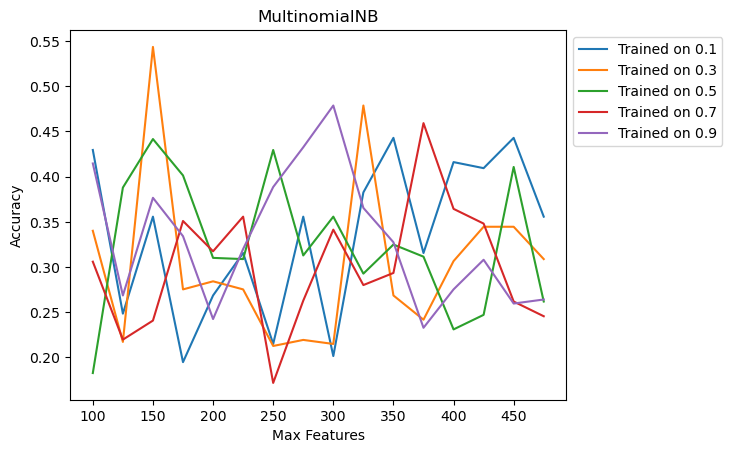

The average accuracy for MultinomialNB was 0.3192348460637051


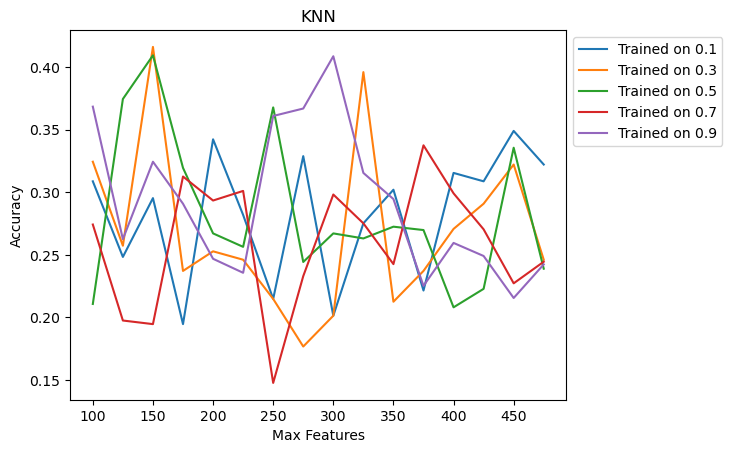

The average accuracy for KNN was 0.27693592201981465


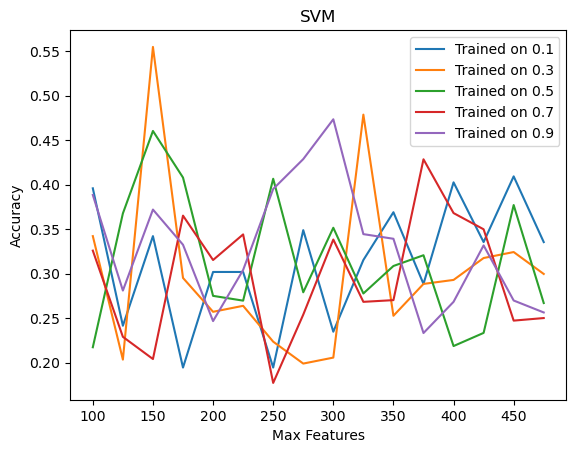

The average accuracy for SVM was 0.31073559177586024


In [48]:
def model_plotter(acc_list_list, model_type):
    for acc, per in zip(acc_list_list, train_percent_list):
        plt.plot(max_feature_list, acc, label = 'Trained on %s' % per)
    plt.xlabel("Max Features")
    plt.ylabel("Accuracy")
    plt.title(model_type)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
print('%s was the most acurate model used %s percent to train with %s features and had an accuracy of %s' 
      % (model_type, params[0]*100, params[1], max_acc))
model_plotter(acc_list_list1, model_types[0])
print('The average accuracy for %s was %s' % (model_types[0], np.mean(np.mean(acc_list_list1, axis=1))))
model_plotter(acc_list_list2, model_types[1])
print('The average accuracy for %s was %s' % (model_types[1], np.mean(np.mean(acc_list_list2, axis=1))))
model_plotter(acc_list_list3, model_types[2])
print('The average accuracy for %s was %s' % (model_types[2], np.mean(np.mean(acc_list_list3, axis=1))))


The best single performance was given by SVM using 150 features and 30% of the training data. The best average performance across all tests was given by MultinomialNB at ~32%. Unsurprisingly KNN did the worst with an average of ~27%. Performance tends to drop off as the number of features grows larger indicating under fitting. In terms of efficiency SMV and MultinomialNB are comparable giving ~55% accuracy with only 30% of the training data. Making either one of those a computationally efficient choice. Although they are both ~40 less accurate than the NMF method.

Lets try out the MultinomialNB modle with a feature size of 150 and 30% of the traning data.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df_train.Text, df_train.Category, test_size=.5)
tfidf_vectorizer = TfidfVectorizer(max_features=200, stop_words=train_filter_words)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# now vectorize the test data
X_test_tfidf = tfidf_vectorizer.fit_transform(df_test.Text.to_numpy())

# train the model
model = MultinomialNB()
model.fit(X_train_tfidf.toarray(), y_train)


# get the predictions for the test data
y_pred = model.predict(X_test_tfidf.toarray())

# and lets put it back into a df so we can submit it to Kaggle
df_test['Category'] = y_pred
# export it to a csv so I can submit to kaggle
df_test[['ArticleId', 'Category']].to_csv('gnb_test_predictions.csv', index = False)

Submitting the results with a train size of 30% and max features set to 150 results in a score of 35%, not very accurate. Varying the training size to 50% and 10% gives a score of 28% and 36% respectively. Similarly varying the max features to 100 and 200 with the training size as 30% results in a score of 36.5% and 30%. Using max features at 200 and a training size of 50% results in a score of 33%. 

Overall the NMF method is much more accurate than any of the unsupervised methods I tried here. 